In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import csv
import umap
import scanpy as sc

In [2]:
import h5py
from scipy.sparse import csr_matrix

def load_data(dataset,gene_percent_cells=0.01,peak_percent_cells=0.001,include_h5=True,
              preprocess=True,sampling=None,distance=1000000):
    
    data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)

    if sampling == 'geosketch':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.sketch.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.sketch.h5ad'.format(dataset)))
    elif sampling == 'uniform':
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.uniform.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.uniform.h5ad'.format(dataset)))        
    else:
        rna_adata = sc.read(os.path.join(data_dir,'{}.rna.h5ad'.format(dataset)))
        atac_adata = sc.read(os.path.join(data_dir,'{}.atac.h5ad'.format(dataset)))

    if dataset == 'sci_car':
        data_dir = '/data/cb/alexwu/mm_finemap/data/sci_car'
        adata = sc.read(os.path.join(data_dir,'adata-hs.h5ad'))

        atac_adata.var['chr_no'] = ['chr' + n for n in atac_adata.var['chr_no']]
        atac_adata.var['start'] = adata.uns['atac.var'][:,2].astype(int)
        atac_adata.var['end'] = adata.uns['atac.var'][:,3].astype(int)

    if preprocess:
        # scale by maximum 
        # (rna already normalized by library size + log-transformed)
        X_max = rna_adata.X.max(0).toarray().squeeze()
        X_max[X_max == 0] = 1
        rna_adata.X = csr_matrix(rna_adata.X / X_max)

        # atac: normalize library size + log transformation
        sc.pp.normalize_total(atac_adata,target_sum=1e4)
        sc.pp.log1p(atac_adata)

    if include_h5:
        data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
        with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
            print(f.keys())
            data_df = pd.DataFrame()
            for k in ['chr_no','eqtl','hic','dist','atac_id','gene','corr','group_corr','gene_percent_cells',
                      'peak_percent_cells','hg38tohg19_eqtl','eqtl.new','corr_bin','group_corr_bin',
                      'hic_0hr','hic_1hr','hic_4hr','eqtl.q','hic_4hr.expectedBL','eqtl.all','hic.new2',
                      'hic.100kb','ABC.score','eqtl.fdr']: #,
#                      'hic_0hr.expectedBL','hic_1hr.expectedBL','hic_4hr.expectedBL.new','hic_0hr.expectedBL.new',
#                      'hic_4hr.expectedBL.new2','hic_12hr.expectedBL','hic_4hr.expectedBL.full']:
                if k in f.keys():
                    data_df[k] = f[k][:]

        small_df = data_df[abs(data_df['dist']) < distance]

        # small_df = small_df[~np.isnan(small_df['group_corr'])]
        small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
        small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

        small_df.index = [(atac_idx,gene) for atac_idx,gene in small_df[['atac_id','gene']].values]
    
        return rna_adata,atac_adata,small_df

    else:
        
        return rna_adata,atac_adata

In [4]:
from scipy.stats import rankdata

def load_results(dataset,eval_df,ensemble=False,gene_percent_cells=0.01,peak_percent_cells=0.001):
    
    n_layers = 10
    n_neighbors = 15
    mode = 'lr'

    eval_df['ABC.score'] = eval_df['ABC.score'].replace(np.nan, 0)
    eval_df['ABC.score'] = eval_df['ABC.score'].values #.astype(bool).astype(float)

    eval_df['corr'] = eval_df['corr'].replace(np.nan, 0)
    eval_df['group_corr'] = eval_df['group_corr'].replace(np.nan, 0)

    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)

    
    if dataset in ['sci_car','snare_seq']:
        
        method = 'graph'
        data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
        for trial_no in range(1,6):

            file_name = 'graph.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
    elif dataset in ['share_seq_more','human_cortex_multiome_lineage']:
        
        method = 'graph'
        for trial_no in range(1,6):

            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}_{}'.format(dataset,trial_no)

            if dataset == 'human_cortex_multiome_lineage':
                file_name = 'graph.uniform.250kb.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            elif dataset == 'share_seq_more':
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)
            else:
                file_name = 'graph.uniform.trial{}.all.max_scale.mseloss.{}layers.nn{}.statistics.txt'.format(trial_no,n_layers,n_neighbors)

            scores = pd.read_csv(os.path.join(data_dir,file_name),sep='\t').values[:,2].astype(float)
            scores[np.isinf(scores)] = 10**10
            eval_df['{}.trial{}'.format(method,trial_no)] = scores
            
        
            if trial_no == 1:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}'.format(dataset)
            else:
                data_dir = '/data/cb/alexwu/mm_finemap/datasets/{}_{}'.format(dataset,trial_no)

            # correlations
            with h5py.File(os.path.join(data_dir,'dataset.h5'),'r') as f:
                data_df = pd.DataFrame()
                for k in ['dist','corr','group_corr','gene_percent_cells','peak_percent_cells']:
                    if k in f.keys():
                        data_df[k] = f[k][:]

            small_df = data_df[abs(data_df['dist']) < distance]

            # small_df = small_df[~np.isnan(small_df['group_corr'])]
            small_df = small_df[small_df['gene_percent_cells'] > gene_percent_cells]
            small_df = small_df[small_df['peak_percent_cells'] > peak_percent_cells]

            eval_df['corr.trial{}'.format(trial_no)] = small_df['corr'].replace(np.nan, 0).values
            eval_df['group_corr.trial{}'.format(trial_no)] = small_df['group_corr'].replace(np.nan, 0).values

    if ensemble:
                
        for method in ['graph','corr','group_corr']:
            eval_df['{}.ranks.mean'.format(method)] = np.array([rankdata(abs(eval_df['{}.trial{}'.format(method,trial_no)].values),
                                                                method='average') for trial_no in range(1,6)]).mean(0)

        distance_ranks = rankdata(-abs(eval_df['dist'].values),method='average')
        eval_df['dist_ranks'] = distance_ranks

        for feature in ['graph.ranks.mean','group_corr.ranks.mean','corr.ranks.mean']:
            eval_df[feature + '-dist'] = (distance_ranks + eval_df[feature].values)/2
            
    return eval_df

In [5]:
from sklearn.metrics import average_precision_score,roc_auc_score

def get_results(dataset,method,n_layers=None,n_neighbors=None,mode=None,sketch=False,trial_no=None):
    
    data_dir = '/data/cb/alexwu/mm_finemap/results/tests_nn/{}'.format(dataset)
    
    if method == 'graph':
        trial_str = 'new2' if trial_no == 0 else 'trial{}'.format(trial_no)
        if sketch:
            file_name = 'graph.sketch.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.{}.all.max_scale.mseloss.{}layers.nn{}.{}.p.txt'.format(trial_str,n_layers,n_neighbors,mode)
    elif method == 'granger':
        if sketch:
            file_name = 'baseline.bin.sketch.bin.results.txt'
        else:
            file_name = 'baseline.bin.bin.results.txt'
    elif method == 'graph.base':
        if sketch:
            file_name = 'graph.base.sketch.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
        else:
            file_name = 'graph.base.new.{}layers.nn{}.{}.txt'.format(n_layers,n_neighbors,mode)
            
    elif method == 'gvar':
        if sketch:
            file_name = 'gvar.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'gvar.bin.trial{}.bin.results.txt'.format(trial_no)

    elif method == 'GVAR':
        if sketch:
            file_name = 'GVAR.bin.sketch.trial{}.bin.results.txt'.format(trial_no)
        else:
            file_name = 'GVAR.bin.trial{}.bin.results.txt'.format(trial_no)
            
    scores = pd.read_csv(os.path.join(data_dir,file_name),header=None).values
    
    if (method == 'graph' and mode == 'lr') or method == 'gvar':
        return scores
    else:
        scores[scores == 0] = 10**-100
        scores = -np.log10(scores)
        return scores
    
def print_results(eval_df,method_list,feature,thresh,direction,metric='auprc'):
    
    if direction == 'less':
        y_true = eval_df[feature].values <= thresh
    elif direction == 'greater':
        y_true = eval_df[feature].values >= thresh

    data_dict = {'method': [], metric: []}
    for method in method_list:
        scores = abs(eval_df[method].values)
                
        if metric == 'auprc':
            value = average_precision_score(y_true,scores)
        elif metric == 'auroc':
            value = roc_auc_score(y_true,scores)
            
        auprc = average_precision_score(y_true,scores)
        data_dict['method'].append(method)
        data_dict[metric].append(value)

    results_df = pd.DataFrame(data_dict)
    results_df['trial_no'] = [int(n.split('trial')[1]) if 'trial' in n else 0 for n in results_df['method']]
    results_df['method'] = [n.split('.trial')[0] for n in results_df['method']]
    
    return results_df

In [15]:
import math

def round_sigfigs(number,significant_digits=3):
    return round(number, significant_digits - int(math.floor(math.log10(abs(number)))) - 1)

def num_sigfigs(number):
    return len(str(number).split('.')[1].strip('0'))
    
def create_plot(results_df,metric):
    
    ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.2,dodge=False)

    sns.stripplot(x='method',y=metric,hue='method',data=results_df,
                  ax=ax,color="black",size=3,alpha=0.8,ci="sd")

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[results_df["method"].nunique():],labels[results_df["method"].nunique():],
               bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
    sns.despine()

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.ylim(0,results_df[metric].max()*1.02)
    plt.xlabel('',fontsize=16)
    plt.ylabel(metric.upper(),fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90)
    
    return ax
    

In [7]:
def distance_matched_df(eval_df,feature,lower_thresh,negpos_ratio=9,seed=1,dist_min=2,verbose=True):
    
    df_copy = eval_df.copy()
    np.random.seed(1)
    
    dist_categories = np.clip(np.log10(0.1+abs(df_copy['dist'].values)).astype(int),dist_min,10)
    df_copy['dist_category'] = dist_categories

    df_list = []
    for group,group_df in df_copy.groupby('dist_category'):
        
        n_per_category = (group_df[feature] <= lower_thresh).sum()
        pos_inds = np.argsort(group_df[feature])[0:n_per_category].tolist()
        neg_inds = np.argsort(group_df[feature])[(-negpos_ratio*n_per_category):]
        neg_inds = list(set(neg_inds) - set(pos_inds))
        
        if verbose:
            print(group,len(pos_inds),len(neg_inds))
        
        df_list.append(group_df.iloc[pos_inds + neg_inds])
    
    return pd.concat(df_list)

In [8]:
def convert_name(n):
    
    if 'graph' in n:
        name = 'GrID-Net'
    elif 'group' in n:
        name = 'Pseudocell Corr'
    elif 'corr' in n:
        name = 'Correlation'
    elif 'ABC' in n:
        name = 'ABC'
    elif "GVAR" in n or "gvar" in n:
        name = "GVAR"
    elif "granger" in n:
        name = "Granger"
    
    
    if 'rra' in n:
        name += ' (RRA)'
        
    if 'ranks' in n:
        name += ' (ens)'
    
    if '-dist' in n:
        name += ' (dist)'
        

    return name

## All Branches

In [9]:
dataset = 'share_seq_more'

distance = 1000000
gene_percent_cells = 0.01
peak_percent_cells = 0.001

# sketch = 'glial' not in dataset
rna_adata,atac_adata,eval_df = load_data(dataset,gene_percent_cells=gene_percent_cells,
                                          peak_percent_cells=peak_percent_cells,
                                          include_h5=True,sampling='uniform',distance=distance)

eval_df = load_results(dataset,eval_df,ensemble=False)
eval_df['abs_dist'] = abs(eval_df['dist'])

Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
Only considering the two last: ['.uniform', '.h5ad'].
<KeysViewHDF5 ['ABC.score', 'atac_id', 'chr_no', 'corr', 'corr.sketch', 'corr_bin', 'dist', 'eqtl.all', 'eqtl.fdr', 'eqtl.q', 'gene', 'gene_percent_cells', 'group_corr', 'group_corr.sketch', 'hic', 'hic.new', 'hic.new2', 'peak_percent_cells']>


In [10]:
data_dir = "/data/cb/alexwu/mm_finemap/results/tests_nn"
for dataset in ["share_seq_both_branches","share_seq_cortex","share_seq_medulla","share_seq_irs"]:
    print(dataset)
    for trial_no in range(1,6):
        df = pd.read_csv(os.path.join(data_dir,"{}_{}".format(dataset,trial_no),"{}_{}.standard_granger.csv".format(dataset,trial_no)))
        eval_df["{}.granger.trial{}".format(dataset,trial_no)] = -np.log10(df["granger_p"].values)

share_seq_both_branches
share_seq_cortex
share_seq_medulla
share_seq_irs


### No Ensembling

In [11]:
data_dir = '/data/cb/alexwu/mm_finemap/data/share_seq/validation'

df = pd.read_csv(os.path.join(data_dir,'GSM2740038_5C-pKerat-R1-zscore-pval-qval.txt.gz'),
                 sep='\t',compression='gzip',header=None)
hic_lower_thresh = -df.values[:,6][df.values[:,8] < 1e-3].min()

In [12]:
name_dict = {'graph': 'GrID-Net',
             'corr': 'Correlation',
             'group_corr': 'Pseudocell Corr',
             'ABC.score': 'ABC',
             'granger': "Linear GC",
             'gvar': "GVAR"}

In [13]:
eqtl_lower_thresh = 1e-10
eval_df_eqtl = eval_df[~np.isnan(eval_df['eqtl.all'])].copy()

# FDR correction
from statsmodels.stats.multitest import fdrcorrection
eval_df_eqtl['eqtl.q'] = fdrcorrection(eval_df_eqtl['eqtl.all'])[1]
eval_df_eqtl = distance_matched_df(eval_df_eqtl,'eqtl.q',eqtl_lower_thresh,negpos_ratio=1,seed=1)

eval_df_hic = eval_df[~np.isnan(eval_df['hic.new2'])].copy()
eval_df_hic['hic.new2.rev'] = -eval_df_hic['hic.new2'].values
# eval_df_hic = eval_df_hic[abs(eval_df_hic['dist']) > 50000]
# hic_lower_thresh = -np.percentile(eval_df_hic['hic.new2'],99)
eval_df_hic = distance_matched_df(eval_df_hic,'hic.new2.rev',hic_lower_thresh,negpos_ratio=1,seed=1,dist_min=5)

2 12 12
3 7 7
4 47 47
5 12 12
5 124 124


In [16]:
def convert_method_name(name):
    if "graph" in name:
        return "GrID-Net (All Branches)"
    
    elif "granger" in name:
        if "both" in name:
            return "GC (All Branches)"
        elif "irs" in name:
            return "GC (" + name.split(".")[0].split("share_seq_")[1].upper() + ")"
        else:
            return "GC (" + name.split(".")[0].split("share_seq_")[1].capitalize() + ")"
        
def set_colors(name):
    if "graph" in name:
        return "mediumseagreen"
    
    elif "granger" in name:
        if "both" in name:
            return "green"
        else:
            return "darkgreen"

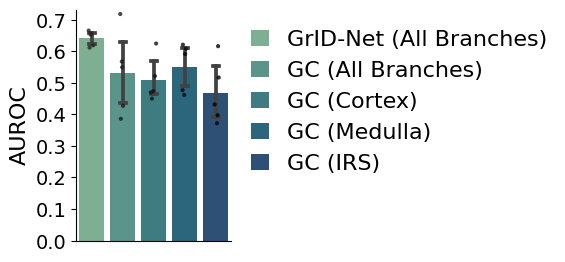

In [17]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
for dataset in ["share_seq_both_branches","share_seq_cortex","share_seq_medulla","share_seq_irs"]:

     method_list.extend(['{}.granger.trial{}'.format(dataset,trial_no) for trial_no in range(1,6)])

feature = 'eqtl.all'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_eqtl,method_list,feature,eqtl_lower_thresh,direction,metric=metric)

results_df['method'] = [convert_method_name(n) for n in results_df['method']]

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))

ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.2,dodge=False,
                 palette=sns.color_palette("crest", 5))
sns.stripplot(x='method',y=metric,hue='method',data=results_df,
              ax=ax,color="black",size=3,alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[results_df["method"].nunique():],labels[results_df["method"].nunique():],
           bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)

plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel('',fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)

#     plt.rcParams['hatch.linewidth'] = 2
# ax.patches[-1].set_edgecolor(ax.patches[-1]._facecolor)
# ax.patches[-1].set_facecolor('white')
# ax.patches[-1].set_hatch('//')
# ax.patches[-1].set_linewidth(2)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()

plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.trajectories.eqtl.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.trajectories.eqtl.0125.csv'.format(dataset)), index=False)
plt.show()

In [18]:
from scipy.stats import ttest_ind

for method in results_df["method"].unique():
    print(method)
    print(ttest_ind(results_df[results_df["method"] == "GrID-Net (All Branches)"]["auroc"],
          results_df[results_df["method"] == method]["auroc"],
          equal_var=False,alternative='greater'))
    print('------')

GrID-Net (All Branches)
Ttest_indResult(statistic=0.0, pvalue=0.5)
------
GC (All Branches)
Ttest_indResult(statistic=1.873950208216044, pvalue=0.06482937765870307)
------
GC (Cortex)
Ttest_indResult(statistic=4.008488120436719, pvalue=0.005269757184663524)
------
GC (Medulla)
Ttest_indResult(statistic=2.501482583346483, pvalue=0.028240571808493525)
------
GC (IRS)
Ttest_indResult(statistic=3.7935044889873413, pvalue=0.00784735418601328)
------


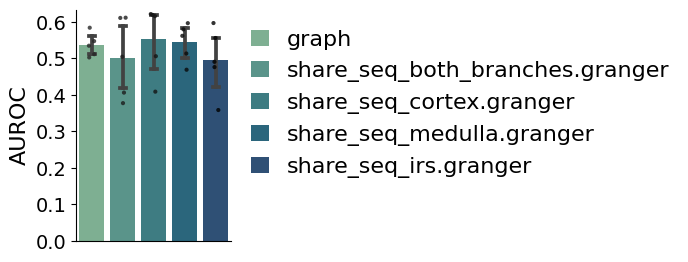

In [19]:
method_list = ['graph.trial{}'.format(trial_no) for trial_no in range(1,6)]
for dataset in ["share_seq_both_branches","share_seq_cortex","share_seq_medulla","share_seq_irs"]:

     method_list.extend(['{}.granger.trial{}'.format(dataset,trial_no) for trial_no in range(1,6)])

feature = 'hic.new2.rev'
direction = 'less'

metric = 'auroc'
results_df = print_results(eval_df_hic,method_list,feature,hic_lower_thresh,direction,metric=metric)
# results_df['method'] = [convert_name(n) for n in results_df['method']]
results_df = results_df[results_df['method'] != 'ABC']

plt.figure(figsize=(len(set(results_df['method']))/2.5,3))
ax = sns.barplot(x='method',y=metric,hue='method',data=results_df,capsize=0.2,dodge=False,
                 palette=sns.color_palette("crest", 5))
sns.stripplot(x='method',y=metric,hue='method',data=results_df,
              ax=ax,color="black",size=3,alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[results_df["method"].nunique():],labels[results_df["method"].nunique():],
           bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)

plt.ylim(0,results_df[metric].max()*1.02)
plt.xlabel('',fontsize=16)
plt.ylabel(metric.upper(),fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(rotation=90)
    
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.legend(bbox_to_anchor=(1,1),fontsize=16,frameon=False,handlelength=0.8)
sns.despine()
plot_dir = '/data/cb/alexwu/mm_finemap/figures'
plt.savefig(os.path.join(plot_dir,'auroc','{}.trajectories.hic.0125.pdf'.format(dataset)), dpi=500, bbox_inches = "tight")
results_df.to_csv(os.path.join(plot_dir,'auroc','{}.eqtl.trajectories.hic.0125.csv'.format(dataset)), index=False)

plt.show()